In [16]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tqdm import tqdm
import os
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import json

# Parameter & Directory setup

In [17]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [2]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'

TRAIN_Q1_DATA_FILE = 'train_q1.npy'
TRAIN_Q2_DATA_FILE = 'train_q2.npy'
TRAIN_LABEL_DATA_FILE = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

TEST_SPLIT = 0.1
RNG_SEED = 13371447

In [3]:
EPOCHS=10
BATCH_SIZE=64

MAX_SEQUENCE_LENGTH = 31

WORD_EMBEDDING_DIM = 100
CONV_FEATURE_DIM = 300
CONV_OUTPUT_DIM = 128
CONV_WINDOW_SIZE = 3
SIMILARITY_DENSE_FEATURE_DIM = 200

# BATCH_SIZE = 128
# NUM_EPOCHS = 10
VALID_SPLIT = 0.1

prepro_configs = None

with open(DATA_IN_PATH + DATA_CONFIGS, 'r') as f:
    prepro_configs = json.load(f)
    
VOCAB_SIZE = prepro_configs['vocab_size']

# Load Dataset

In [4]:
q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE, 'rb'))
labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE, 'rb'))

# Model setup

In [5]:
class SentenceEmbedding(tf.keras.Model):
    def __init__(self, conv_dims, output_dims, window_size, max_len, name='', dropout_rate=0.2):
        super(SentenceEmbedding, self).__init__()
        self.model = tf.keras.Sequential([
            tf.keras.layers.Conv1D(CONV_FEATURE_DIM, CONV_WINDOW_SIZE, 
                                    activation=tf.nn.relu, 
                                    name=name + 'conv_1d',
                                    padding='same'),
            tf.keras.layers.MaxPool1D(MAX_SEQUENCE_LENGTH, 1),
            tf.keras.layers.Dense(CONV_OUTPUT_DIM, activation=tf.nn.relu, name=name + 'dense'),
        ])
    def call(self, inputs):
        outputs = self.model(inputs)
        return tf.squeeze(outputs, 1)

In [6]:
class SentenceSimilarityModel(tf.keras.Model):
    def __init__(self, word_size, word_dims, hidden_dims, base_encoder, hypo_encoder, dropout_rate=0.2):
        super(SentenceSimilarityModel, self).__init__()
        
        self.word_embedding = tf.keras.layers.Embedding(word_size, word_dims)
        self.base_encoder = base_encoder
        self.hypo_encoder = hypo_encoder
        self.dense = tf.keras.layers.Dense(hidden_dims, activation=tf.nn.relu)
        self.logit = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, inputs):
        base_embedded = self.word_embedding(inputs[0])
        hypo_embedded = self.word_embedding(inputs[1])
        base_embedded = self.dropout(base_embedded)
        hypo_embedded = self.dropout(hypo_embedded)
        
        base_encoded = self.base_encoder(base_embedded)
        hypo_encoded = self.hypo_encoder(hypo_embedded)
        
        encoded = tf.concat([base_encoded, hypo_encoded], -1)
        sim_encoded = self.dense(encoded)
        sim_encoded = self.dropout(sim_encoded)
        
        return self.logit(sim_encoded)

In [7]:
base_encoder = SentenceEmbedding(CONV_FEATURE_DIM, CONV_OUTPUT_DIM, CONV_WINDOW_SIZE, MAX_SEQUENCE_LENGTH, name='base')
hypo_encoder = SentenceEmbedding(CONV_FEATURE_DIM, CONV_OUTPUT_DIM, CONV_WINDOW_SIZE, MAX_SEQUENCE_LENGTH, name='hypo')
similarity_model = SentenceSimilarityModel(VOCAB_SIZE, WORD_EMBEDDING_DIM, SIMILARITY_DENSE_FEATURE_DIM, 
                                           base_encoder, hypo_encoder)

In [8]:
base = tf.keras.Input([MAX_SEQUENCE_LENGTH])
hypothesis = tf.keras.Input([MAX_SEQUENCE_LENGTH])

similarity = similarity_model([base, hypothesis])
model = tf.keras.Model([base, hypothesis], similarity)

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
sentence_similarity_model (Sent (None, 1)            7963857     input_1[0][0]                    
                                                                 input_2[0][0]                    
Total params: 7,963,857
Trainable params: 7,963,857
Non-trainable params: 0
__________________________________________________________________________________________________
None


## 모델 학습 및 평가

In [10]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

history = model.fit([q1_data, q2_data], labels, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback])

Train on 268673 samples, validate on 29853 samples
Epoch 1/10
268673/268673 [==============================] - 342s 1ms/sample - loss: 0.5623 - accuracy: 0.7069 - val_loss: 0.5772 - val_accuracy: 0.6824
Epoch 2/10
268673/268673 [==============================] - 336s 1ms/sample - loss: 0.4820 - accuracy: 0.7700 - val_loss: 0.5036 - val_accuracy: 0.7471
Epoch 3/10
268673/268673 [==============================] - 336s 1ms/sample - loss: 0.4307 - accuracy: 0.8014 - val_loss: 0.4983 - val_accuracy: 0.7537
Epoch 4/10
268673/268673 [==============================] - 339s 1ms/sample - loss: 0.3752 - accuracy: 0.8316 - val_loss: 0.6568 - val_accuracy: 0.6769


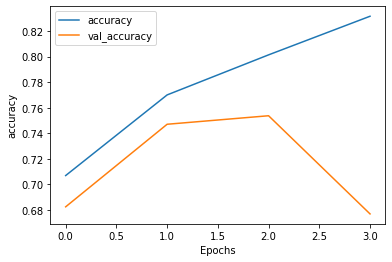

In [18]:
plot_graphs(history, 'accuracy')

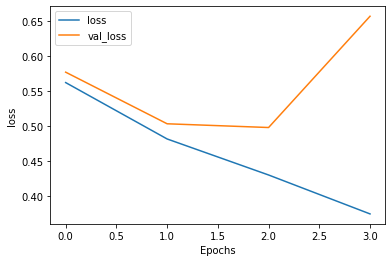

In [19]:
plot_graphs(history, 'loss')

## 캐글 데이터셋 준비 및 제출

In [11]:
TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA_FILE, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA_FILE, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'), allow_pickle=True)

In [12]:
BLOCK_SIZE = 500

predictions = [model([test_q1_data[i*BLOCK_SIZE:i*BLOCK_SIZE+BLOCK_SIZE], \
                      test_q2_data[i*BLOCK_SIZE:i*BLOCK_SIZE+BLOCK_SIZE]]).numpy() \
               for i in tqdm(range(test_q1_data.shape[0] // BLOCK_SIZE + 1))]

100%|██████████| 4692/4692 [04:08<00:00, 18.89it/s]


In [13]:
predictions = np.concatenate(predictions, axis=-2).squeeze(-1)

In [14]:
output = pd.DataFrame( data={"test_id":test_id_data, "is_duplicate": list(predictions)} )
output.to_csv("cnn_predict.csv", index=False, quoting=3)

![alt text](images/cnn_result.png "Title") 